# Redes Geradoras Adversárias - GAN (Generative Adversarial Networks )

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

''' Serve para garantir que os resultados do código sejam sempre os mesmos, 
    mesmo quando envolvem sorte ou aleatoriedade (como pesos iniciais de redes neurais, 
    embaralhamento de dados, etc).'''
    
tf.random.set_seed(1)



# carregar o dataser Fashion MNIST 
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

* ####  Conforme realizado anteriormente, será utilizado o conjunto de dados Fashion MNIST. 
* #### Neste caso, os dados de treinamento e teste serão unificados, uma vez que não será realizada a separação entre essas etapas. 
* #### Além disso, os dados serão normalizados da mesma forma como foi feito no modelo de Autoencoder Variacional (VAE)

---

In [2]:
import numpy as np


dataset = np.concatenate([x_train, x_test], axis=0)

dataset = np.expand_dims(dataset, -1).astype("float32") / 255

* ## O que isso faz?

    * #### As imagens vêm com valores de pixels entre 0 e 255 (tons de cinza).

    * #### Dividir por 255 transforma esses valores para o intervalo [0, 1].

    * #### .astype("float32") garante que os dados estejam no tipo adequado para o TensorFlow (evita erros e melhora desempenho).

    * #### np.expand_dims(..., -1) adiciona uma dimensão extra (forma [28, 28, 1]), indicando que é uma imagem com 1 canal (preto e branco).

* ## Por que isso é importante?
    * #### Redes neurais funcionam melhor com entradas normalizadas.

    * #### Ajuda a evitar problemas de instabilidade no treinamento.

    * #### Melhora a convergência e a precisão numérica dos cálculos.
---

In [3]:
BATCH_SIZE = 64

dataset = np.reshape(dataset, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

* ### Agora vamos redimensionar os dados para as dimensões necessárias pelas camadas convolucionais (CNN), embaralhá-los e agrupá-los em lotes:

* ### Redimensionar (reshape)
    * CNNs esperam entradas no formato [altura, largura, canais].
* ### Transformar em Dataset	
    * Permite carregar e alimentar os dados de forma eficiente.
* ### Embaralhar (shuffle)	
    * Evita viés na ordem dos dados (melhora generalização).
* ### Agrupar em lotes (batch)	
    * Acelera o treino e melhora estabilidade nos gradientes.
---

# Gerador

* ### O gerador é o coração da GAN — é ele quem tenta enganar o discriminador criando imagens falsas cada vez mais realistas.

* ### Usar camadas Conv2DTranspose permite que ele construa imagens de baixa para alta resolução.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

# a entrada do gerador é um vetor de ruído
# hiperparâmetro que também requer ajuste fino
NOISE_DIM = 150

# projetar um modelo de gerador com camadas de upsampling
# em práticas com GANs, geralmente o gerador usa ativação leaky relu enquanto o discriminador usa relu
generator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(NOISE_DIM,)),
  layers.Dense(7*7*256),
  layers.Reshape(target_shape=(7, 7, 256)),
  layers.Conv2DTranspose(256, 3, activation="LeakyReLU", strides=2, padding="same"),
  layers.Conv2DTranspose(128, 3, activation="LeakyReLU", strides=2, padding="same"),
  layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1894144   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        1153      
 ranspose)                                                       
                                                        

* ### A estrutura definida aqui transforma um simples vetor de ruído em uma imagem com formato 28x28x1 (como as do Fashion MNIST).
---

# Discriminador
* ### Em seguida, vamos criar nosso modelo de discriminador, usando duas camadas Conv2D para reduzir a dimensionalidade (downsampling) antes de passar por uma camada densa com 64 neurônios e uma camada de dropout para evitar overfitting. Sua saída é binária, pois sua função é classificar imagens como 'reais' ou 'falsas'... até que não consiga mais notar a diferença

In [5]:
# design a discriminator with downsampling layers
discriminator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),
  layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
  layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
  layers.Flatten(),
  layers.Dense(64, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 699,137
Trainable params: 699,137
Non-tr

* #### O discriminador é a parte que aprende a diferenciar imagens reais das falsas.

* #### Ele é o adversário do gerador. Quanto melhor ele ficar em distinguir imagens, mais desafiador será para o gerador.

* #### Durante o treinamento da GAN, o objetivo do gerador é enganar o discriminador; e o objetivo do discriminador é não ser enganado.

* #### Esse equilíbrio entre os dois leva a um processo de aprendizagem cada vez mais refinado, até que o gerador produza imagens tão boas que o discriminador não consiga mais notar a diferença.
---

# Otimizadores
* ### Configure nossos otimizadores, função de perda e métricas de precisão. Ajustar as taxas de aprendizado corretamente tanto para o gerador quanto para o discriminador é a chave. Caso contrário, o modelo não será estável.

In [6]:
# Queremos manter o equilíbrio do jogo até chegarmos ao equilíbrio de Nash. 
# Se o discriminador ficar muito forte ou muito fraco, o jogo adversarial falha
# Taxas de aprendizado mais altas impactam severamente a estabilidade do jogo adversarial

optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

# classificação binária (real or falso)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

# métrica de acurácia
gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()

* ### **Equilíbrio de Nash**: Esse é um conceito fundamental em jogos de teoria dos jogos, onde nenhuma das partes (gerador ou discriminador) pode melhorar sua posição sem prejudicar a outra. O treinamento de uma GAN é um jogo entre duas redes, e se o discriminador fica muito forte (consegue distinguir facilmente entre imagens reais e falsas), o gerador não aprende mais. Por outro lado, se o discriminador fica muito fraco, o gerador não é desafiado a melhorar.

* ###  **Taxas de Aprendizado e Estabilidade**: A escolha correta das taxas de aprendizado ajuda a manter o jogo equilibrado e estável. Taxas de aprendizado muito altas podem levar a flutuações nos resultados, enquanto taxas muito baixas podem fazer o treinamento ser muito lento ou estagnar.
---

* ### Inicialmente alimentamos o gerador com ruído gaussiano. Suas saídas 'falsas' são concatenadas com os dados 'reais' que são passados para o discriminador. O discriminador faz o seu melhor para identificar os rótulos de real vs. falso. Aqui definimos a função de treinamento para o discriminador

In [7]:
@tf.function
def trainDStep(data):
  # o lote tem a forma (32, 28, 28, 1), então extraímos o valor 32
  batchSize = tf.shape(data)[0]

  # crie um vetor de ruído como entrada para o gerador amostrado de uma distribuição normal gaussiana
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))

  # concatene os rótulos reais e falsos
  y_true = tf.concat(
    [
      # os dados originais são reais, rotulados como 1
      tf.ones(batchSize, 1),
      # os dados forjados são falsos, rotulados como 0
      tf.zeros(batchSize, 1)
    ],
    axis=0
  )

  # registra os gradientes calculados
  with tf.GradientTape() as tape:
    # gera amostras forjadas
    fake = generator(noise)
    # concatene dados reais e dados forjados
    x = tf.concat([data, fake], axis=0)
    # verifica se o discriminador os detecta
    y_pred = discriminator(x)
    # calculo da perda
    discriminatorLoss = lossFn(y_true, y_pred)

  # aplica o caminho reverso e atualiza os pesos
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

  # relatório a precisão (accuracy)
  dAccMetric.update_state(y_true, y_pred)

  # retorna a visualização de perda
  return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetric.result()
  }

* ### Esse passo é fundamental no ciclo de treinamento da GAN: ele treina o discriminador, que precisa se tornar bom em detectar o que é real e o que é gerado.

* ### A forma como os dados são misturados e rotulados aqui permite que o discriminador aprenda corretamente.

* ### A utilização do @tf.function permite que o TensorFlow compile a função de forma mais eficiente, acelerando o treinamento.
---

* ### E agora, a função de treinamento do gerador. Lembre-se de que o gerador está tentando não ser pego, então ele quer ser classificado como real. 
* ### Sua função de perda se baseia em quantas vezes o discriminador classifica suas amostras falsas como reais. Isso está em tensão com o discriminador, que está tentando encontrar falsificações.

In [8]:
@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))
  # ao treinar o gerador, queremos maximizar a probabilidade de que sua saída seja classificada como real 
  # lembre-se do jogo de soma zero (min-max) entre gerador e discriminador
  y_true = tf.ones(batchSize, 1)

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred)

  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

  gAccMetric.update_state(y_true, y_pred)

  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
  }

## Essa função é a outra metade do “jogo adversarial” da GAN:

* ### O gerador tenta enganar o discriminador.

* ### Ele só é "recompensado" (menor perda) se conseguir produzir imagens tão realistas que o discriminador acredite que são reais.

* ### O treino do gerador só acontece com base nas respostas do discriminador.

* ### Isso é o que caracteriza o jogo min-max das GANs:

* ### O gerador tenta minimizar sua perda (enganar),

* ### Enquanto o discriminador tenta maximizar a sua (detectar os falsos).
---

## Visualização

* ### vamos criar uma função prática para visualizar as imagens geradas durante o treinamento

In [9]:
from matplotlib import pyplot as plt


def plotImages(model):
    images = model(np.random.normal(size=(81, NOISE_DIM)))

    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis('off')

    plt.show()

---

* ### Como o jogo adversarial é um equilíbrio delicado, queremos observar os resultados à medida que o treinamento avança. Ele pode convergir e depois divergir novamente.
* ### Aqui apenas passamos por cada lote, treinamos o discriminador e o gerador a cada época. 
* ### A cada duas épocas, daremos uma espiada em algumas imagens geradas para ver como estão, à medida que o gerador aprende distribuições de probabilidade para representar imagens realistas.

Época:0, Perda G:0.6648, Perda D:0.5363, Acurácia G:0.45%, Acurácia D:92.19%, Duração: 391.09s


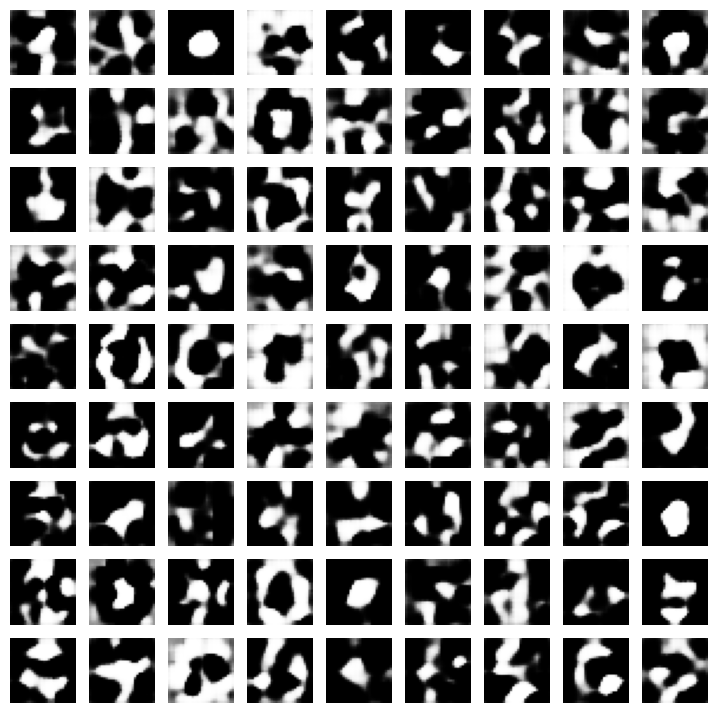

Época:1, Perda G:0.6761, Perda D:0.5260, Acurácia G:0.98%, Acurácia D:96.53%, Duração: 388.33s
Época:2, Perda G:0.6805, Perda D:0.5224, Acurácia G:0.93%, Acurácia D:96.91%, Duração: 387.14s


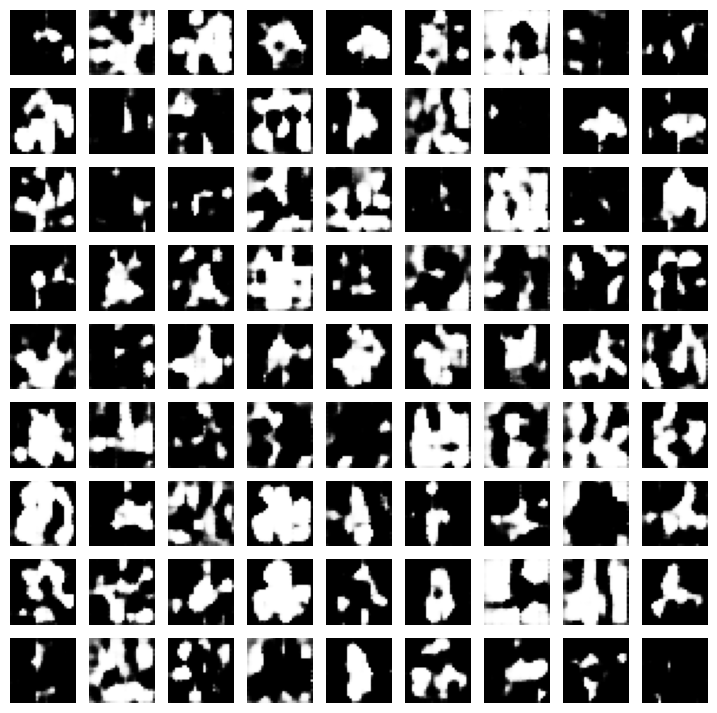

Época:3, Perda G:0.6855, Perda D:0.5159, Acurácia G:0.82%, Acurácia D:97.18%, Duração: 444.16s
Época:4, Perda G:0.6871, Perda D:0.5138, Acurácia G:0.70%, Acurácia D:97.45%, Duração: 431.39s


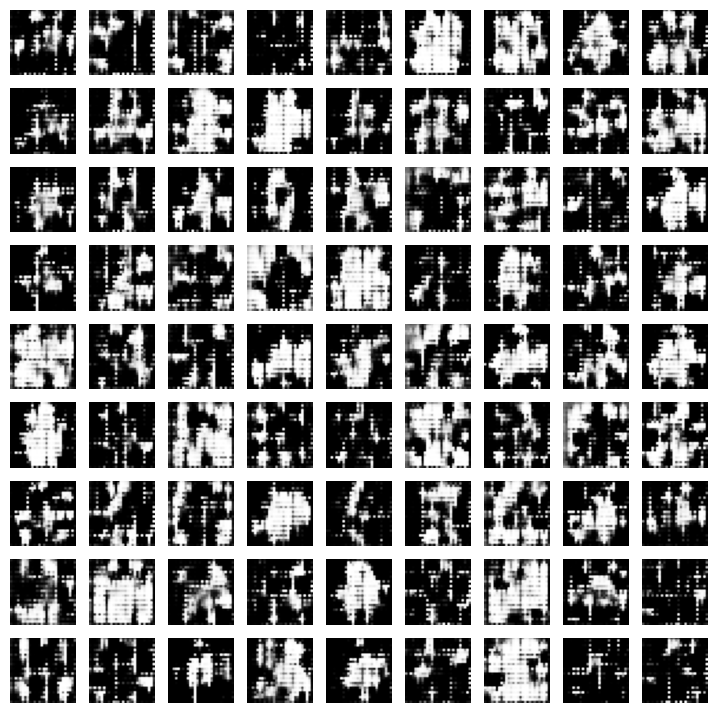

Época:5, Perda G:0.6737, Perda D:0.5416, Acurácia G:0.74%, Acurácia D:97.36%, Duração: 419.89s
Época:6, Perda G:0.6444, Perda D:0.6237, Acurácia G:1.60%, Acurácia D:94.73%, Duração: 414.74s


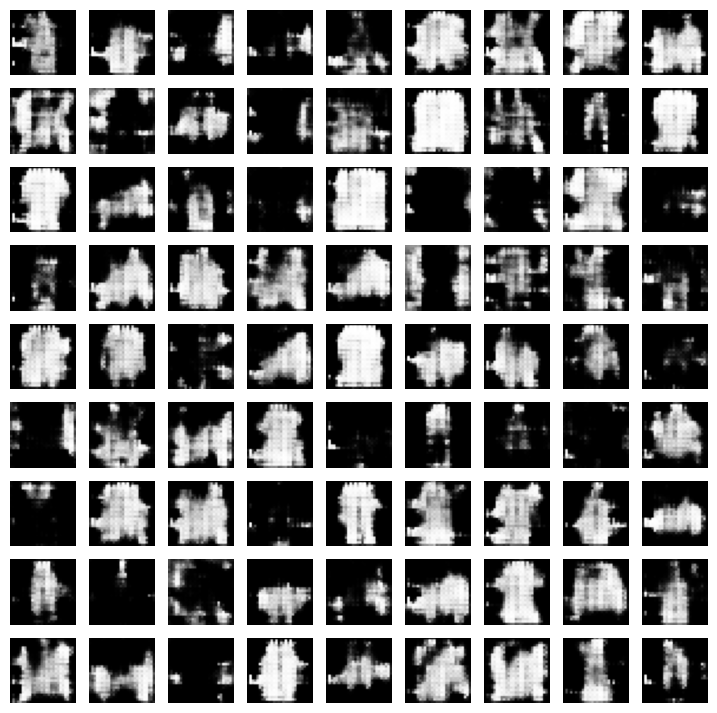

Época:7, Perda G:0.6400, Perda D:0.6256, Acurácia G:2.49%, Acurácia D:91.69%, Duração: 416.06s
Época:8, Perda G:0.6451, Perda D:0.6340, Acurácia G:3.02%, Acurácia D:89.22%, Duração: 419.60s


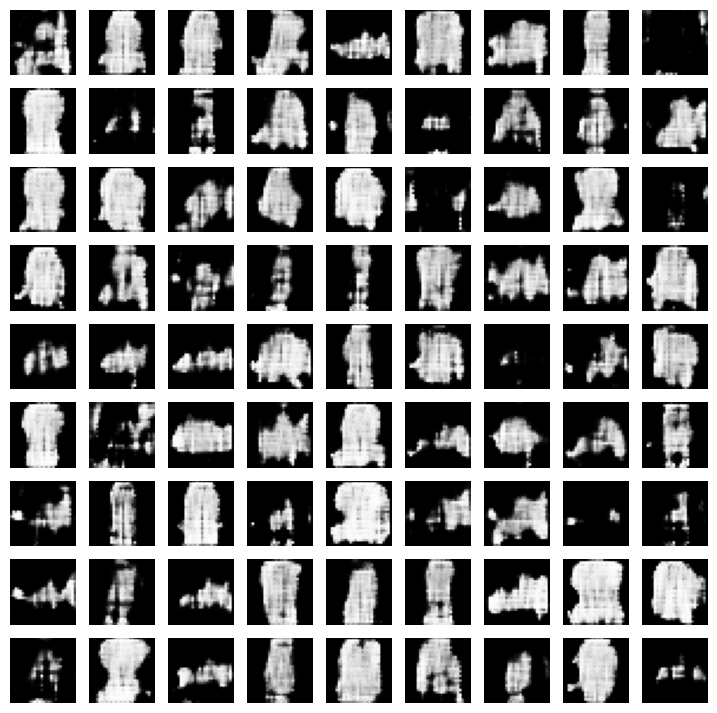

Época:9, Perda G:0.6460, Perda D:0.6349, Acurácia G:3.24%, Acurácia D:87.13%, Duração: 415.53s
Época:10, Perda G:0.6422, Perda D:0.6396, Acurácia G:3.44%, Acurácia D:85.30%, Duração: 413.60s


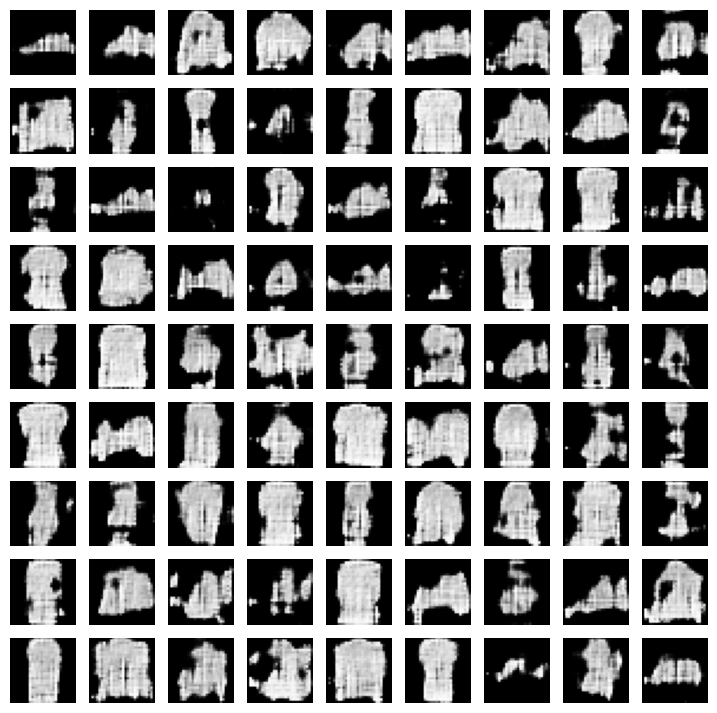

Época:11, Perda G:0.6400, Perda D:0.6284, Acurácia G:3.66%, Acurácia D:83.95%, Duração: 412.31s
Época:12, Perda G:0.6388, Perda D:0.6173, Acurácia G:3.83%, Acurácia D:83.09%, Duração: 411.99s


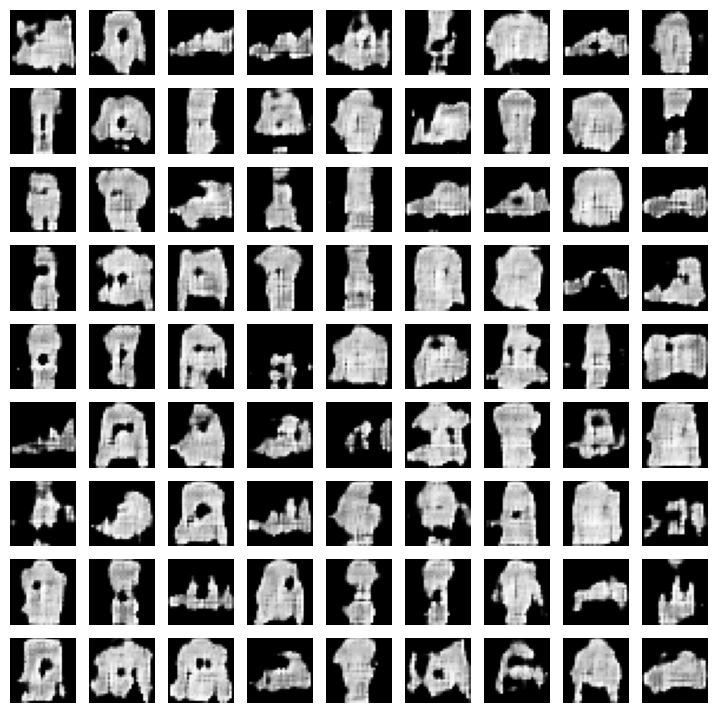

Época:13, Perda G:0.6382, Perda D:0.6158, Acurácia G:3.96%, Acurácia D:82.50%, Duração: 410.14s
Época:14, Perda G:0.6385, Perda D:0.6138, Acurácia G:4.08%, Acurácia D:82.02%, Duração: 412.15s


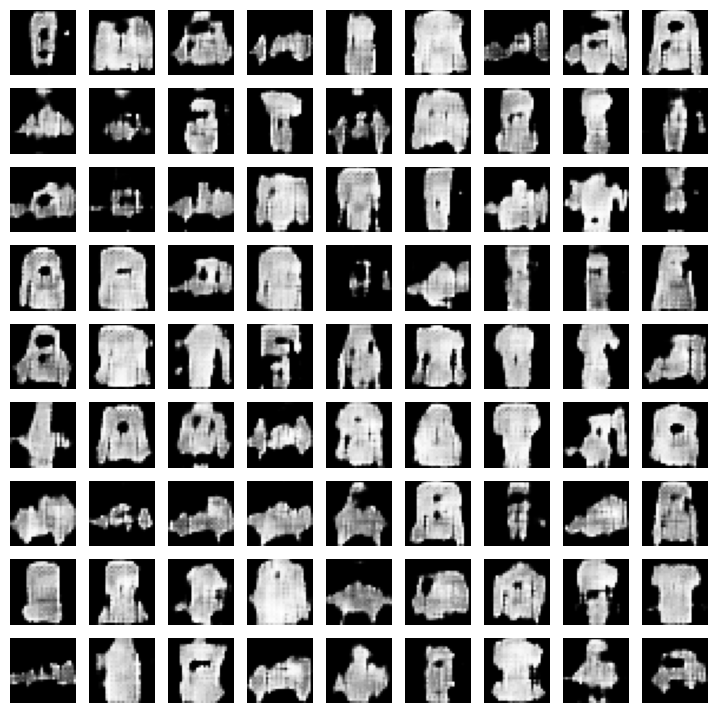

Época:15, Perda G:0.6409, Perda D:0.6076, Acurácia G:4.16%, Acurácia D:81.68%, Duração: 410.64s
Época:16, Perda G:0.6429, Perda D:0.6069, Acurácia G:4.20%, Acurácia D:81.43%, Duração: 407.92s


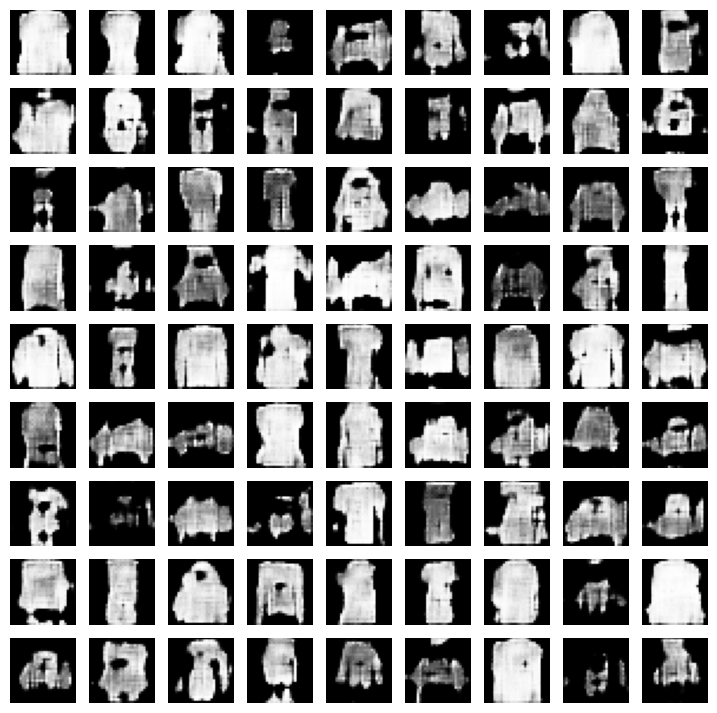

Época:17, Perda G:0.6434, Perda D:0.6055, Acurácia G:4.24%, Acurácia D:81.19%, Duração: 409.68s
Época:18, Perda G:0.6439, Perda D:0.6067, Acurácia G:4.29%, Acurácia D:80.97%, Duração: 411.85s


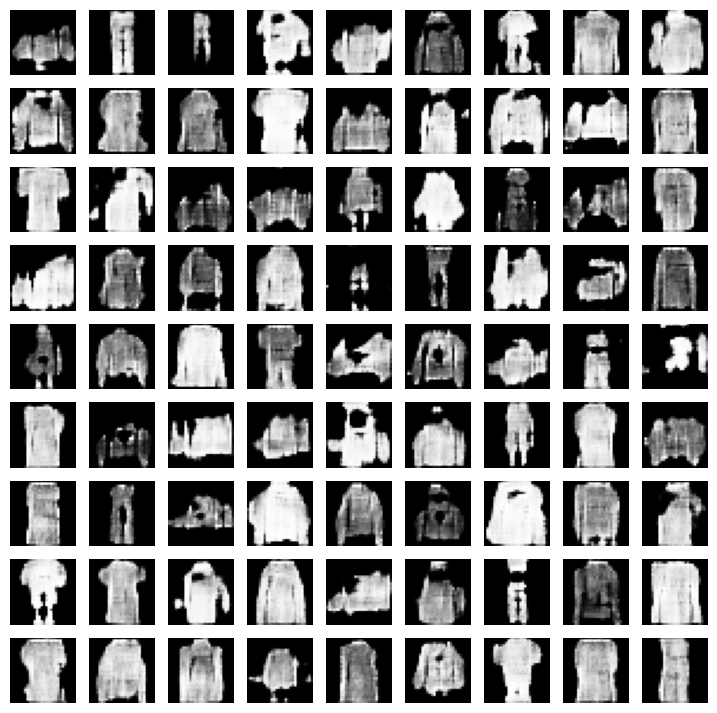

Época:19, Perda G:0.6446, Perda D:0.6064, Acurácia G:4.33%, Acurácia D:80.75%, Duração: 412.27s
Época:20, Perda G:0.6458, Perda D:0.6062, Acurácia G:4.36%, Acurácia D:80.54%, Duração: 407.76s


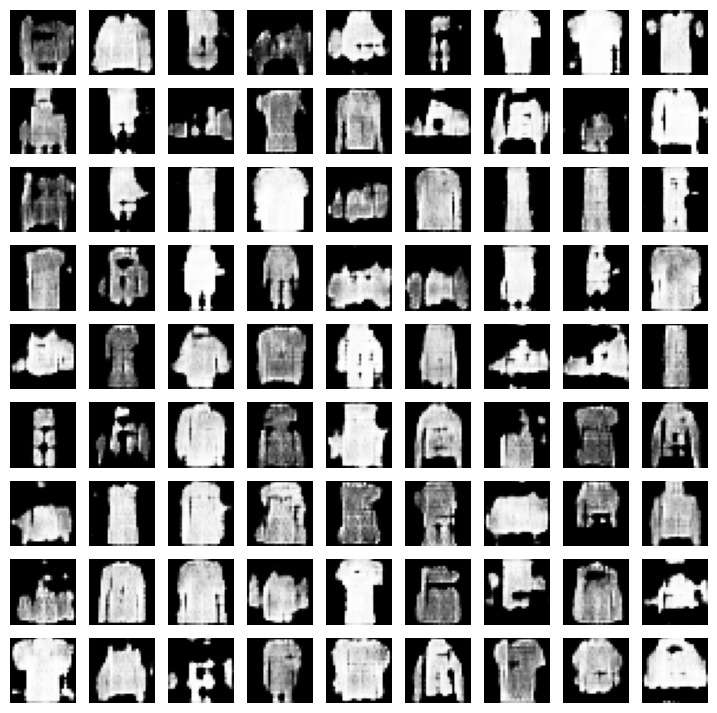

Época:21, Perda G:0.6475, Perda D:0.6055, Acurácia G:4.37%, Acurácia D:80.36%, Duração: 413.33s
Época:22, Perda G:0.6480, Perda D:0.6051, Acurácia G:4.35%, Acurácia D:80.19%, Duração: 409.91s


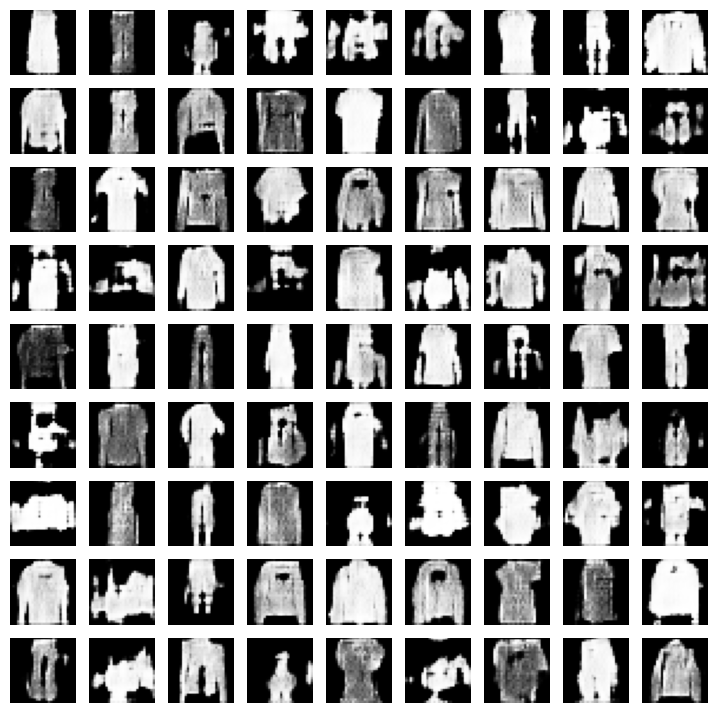

Época:23, Perda G:0.6483, Perda D:0.6055, Acurácia G:4.33%, Acurácia D:80.03%, Duração: 410.15s
Época:24, Perda G:0.6476, Perda D:0.6052, Acurácia G:4.31%, Acurácia D:79.87%, Duração: 409.56s


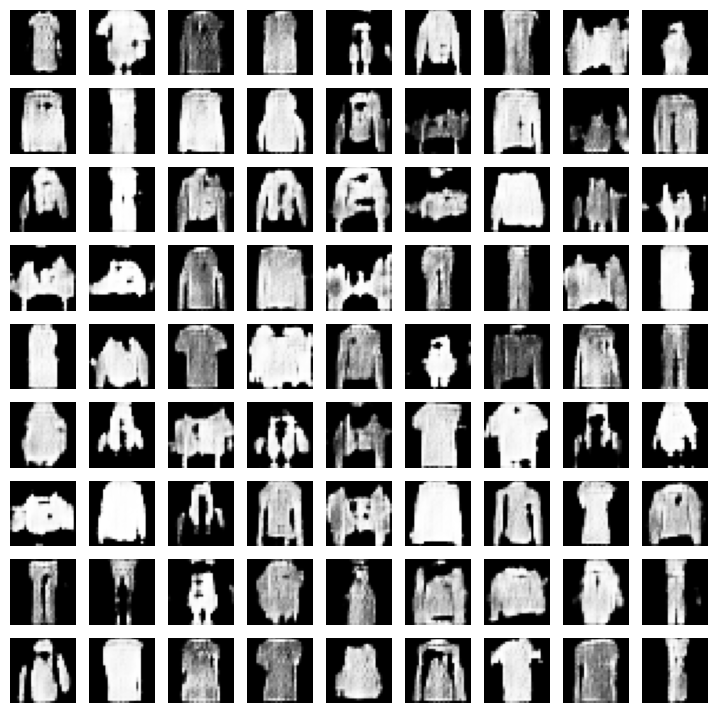

Época:25, Perda G:0.6480, Perda D:0.6054, Acurácia G:4.29%, Acurácia D:79.73%, Duração: 414.47s
Época:26, Perda G:0.6503, Perda D:0.6073, Acurácia G:4.25%, Acurácia D:79.58%, Duração: 410.26s


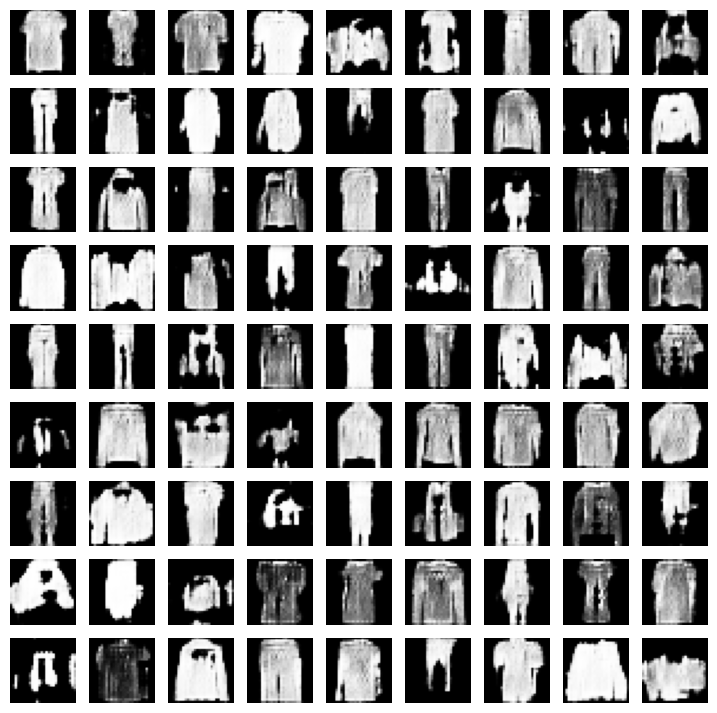

Época:27, Perda G:0.6506, Perda D:0.6067, Acurácia G:4.21%, Acurácia D:79.41%, Duração: 411.57s
Época:28, Perda G:0.6526, Perda D:0.6074, Acurácia G:4.16%, Acurácia D:79.26%, Duração: 411.19s


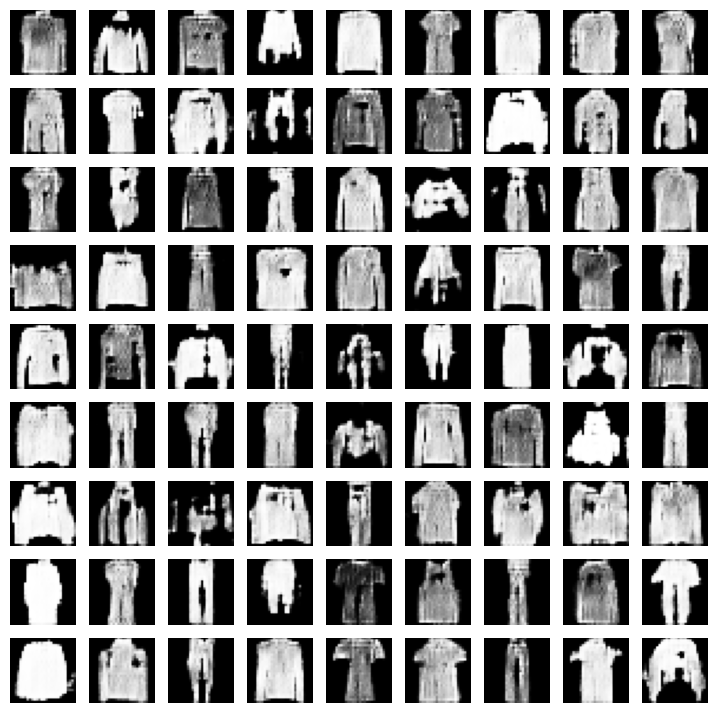

Época:29, Perda G:0.6540, Perda D:0.6075, Acurácia G:4.10%, Acurácia D:79.11%, Duração: 411.93s


In [10]:
import time  # importar o módulo de tempo

# não usamos mais o método model.fit, pois o artigo original das GANs
# treinava o discriminador por 5 passos e depois o gerador por 1 passo
# o valor 5 pode ser ajustado de acordo com o design do modelo e o conjunto de dados
# neste exemplo, treinamos ambos por 1 passo
# observação: o jogo adversarial pode divergir após ter convergido
# por isso é comum visualizar as imagens geradas a cada poucas épocas
# alguns até juntam as imagens em um vídeo

for epoca in range(30):
    inicio_tempo = time.time()  # marca o tempo inicial da época

    # acumular as perdas para calcular a média no final da época
    soma_perda_D = 0
    soma_perda_G = 0
    soma_acc_D = 0
    soma_acc_G = 0
    contador = 0

    # percorrer o conjunto de dados, lote por lote
    for lote in dataset:

        # treinar o discriminador
        # lembre-se: essas 2 linhas podem ser repetidas K vezes, se necessário
        perda_D = trainDStep(lote)
        soma_perda_D += perda_D['discriminator_loss']
        soma_acc_D += perda_D['discriminator_accuracy']

        # treinar o gerador
        perda_G = trainGStep(lote)
        soma_perda_G += perda_G['generator_loss']
        soma_acc_G += perda_G['generator_accuracy']

        # incrementar o contador
        contador += 1

    fim_tempo = time.time()  # marca o tempo final da época
    duracao = fim_tempo - inicio_tempo  # calcula a duração

    # registrar o desempenho
    print("Época:{}, Perda G:{:0.4f}, Perda D:{:0.4f}, Acurácia G:{:0.2f}%, Acurácia D:{:0.2f}%, Duração: {:0.2f}s".format(
        epoca,
        soma_perda_G / contador,
        soma_perda_D / contador,
        100 * soma_acc_G / contador,
        100 * soma_acc_D / contador,
        duracao
    ))

    # a cada 2 épocas, visualizar algumas imagens geradas
    if epoca % 2 == 0:
        plotImages(generator)


* ### Controle da estabilidade: GANs são notoriamente difíceis de treinar. Às vezes elas "aprendem demais", ou colapsam. Monitorar as métricas e imagens ajuda a saber se o treinamento está indo bem.

* ### Balanceamento entre os modelos: O gerador e o discriminador estão em constante competição. Um não pode ficar muito melhor que o outro, ou o sistema para de aprender.

* ### Ajustes finos: A visualização e os logs permitem que você perceba quando algo está errado, como imagens sem sentido ou acurácia do discriminador muito alta (o que pode significar que o gerador está fraco).
---


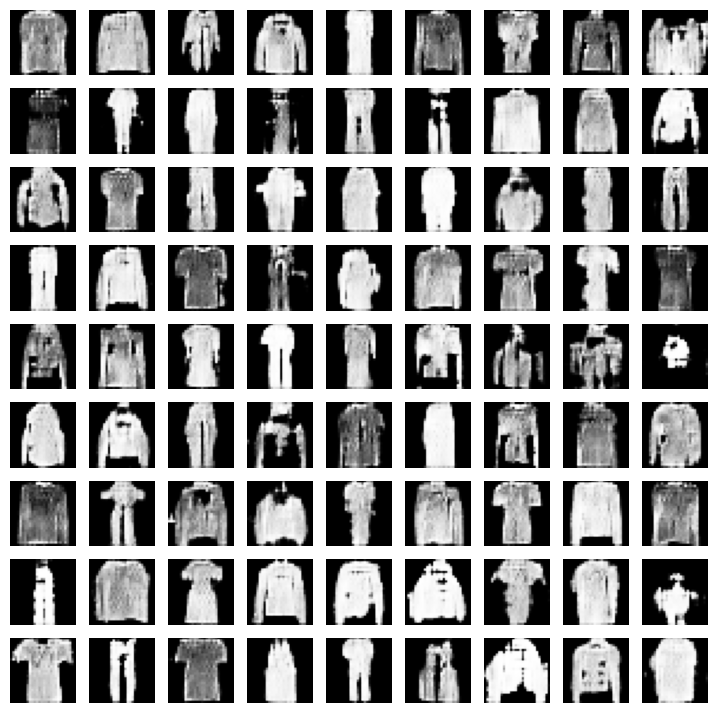

In [11]:
# gera algumas imagens com o modelo treinado
# observa como isso é rápido em comparação com renderizar uma imagem usando algoritmos gráficos tradicionais
# por isso as GANs podem revolucionar a indústria dos videogames ao gerar cenas realistas
# observe como as amostras geradas parecem pertencer à mesma ou a classes semelhantes; isso é o
# "problema de colapso de modo" das GANs.

images = generator(np.random.normal(size=(81, NOISE_DIM)))

# plotar amostras geradas 
from matplotlib import pyplot as plt

plt.figure(figsize=(9, 9))

for i, image in enumerate(images):
    plt.subplot(9,9,i+1)
    plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
    plt.axis('off')

plt.show();

* ### Verificação visual da performance: Visualizar o que o gerador aprendeu é a forma mais direta de avaliar se ele está realmente produzindo algo coerente com o conjunto de dados real.

* ### Identificação de problemas como "mode collapse": Quando o gerador aprende a criar apenas um ou poucos tipos de imagem (por exemplo, sempre um 3, ou sempre um 7 no caso do MNIST), isso indica que ele "colapsou" para um único modo da distribuição, perdendo diversidade.

* ### Aplicações práticas: O autor menciona que o processo é extremamente rápido, e esse é um dos motivos pelos quais GANs têm grande potencial para aplicações como geração de conteúdo para jogos e realidade virtual.
---